
# An Application Using NASDAQ BTC Data

This chapter will use the NASDAQ data link to download some BTC price and return data. We'll also see our first set of **simulations**.

We'll need to install a few packages to access the Nasdaq data.

https://docs.data.nasdaq.com/docs/python-installation


`pip` is a way to install packages via the command line. This should code should install any package to your Anaconda distribution of Python.

```
pip install nasdaq-data-link
pip install quandl
```


In [1]:
# Set-up

import nasdaqdatalink
import quandl

import numpy as np
import pandas as pd

import matplotlib as mpl 

import matplotlib.pyplot as plt

quandl.ApiConfig.api_key = 'kVxf2sQJhQbFtym4MXv3'

In [2]:
btc = quandl.get("BCHAIN/MKPRU")
btc.tail()

,Value
Date,
2022-02-23,38262.17
2022-02-24,37291.48
2022-02-25,38344.78
2022-02-26,39222.60
2022-02-27,39103.91


In [3]:
btc['ret'] = btc.pct_change().dropna()


<AxesSubplot:xlabel='Date'>

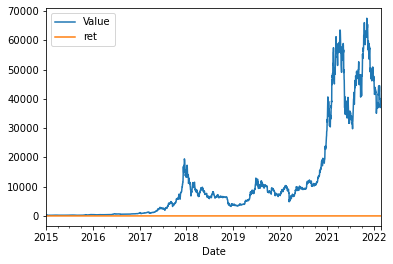

In [4]:
btc = btc.loc['2015-01-01':,['Value', 'ret']]
btc.plot()

In [5]:
print(f'Average return: {100 * btc.ret.mean():.2f}%')

Average return: 0.26%


Make a cumulative return chart and daily return chart. Stack on top of each other.

In [6]:
btc['ret_g'] = btc.ret.add(1) # gross return
btc['ret_c'] = btc.ret_g.cumprod().sub(1)    # cummulative return
btc

,Value,ret,ret_g,ret_c
Date,,,,
2015-01-01,316.15,0.001425,1.001425,0.001425
2015-01-02,314.81,-0.004238,0.995762,-0.002819
2015-01-03,270.93,-0.139386,0.860614,-0.141812
2015-01-04,276.80,0.021666,1.021666,-0.123218
2015-01-05,263.17,-0.049241,0.950759,-0.166392
...,...,...,...,...
2022-02-23,38262.17,0.033245,1.033245,120.197878
2022-02-24,37291.48,-0.025369,0.974631,117.123155
2022-02-25,38344.78,0.028245,1.028245,120.459550


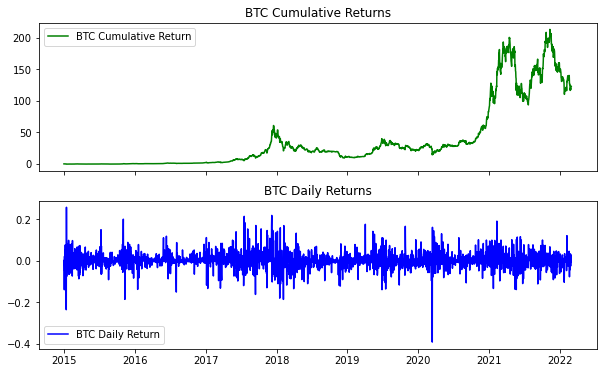

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 6))

axs[0].plot(btc.ret_c, 'g', label = 'BTC Cumulative Return')
axs[1].plot(btc.ret, 'b', label = 'BTC Daily Return')
            
axs[0].set_title('BTC Cumulative Returns')
axs[1].set_title('BTC Daily Returns')

axs[0].legend()
axs[1].legend()




I can make the same graph using the `.add_subplot()` syntax. The method above gives you some more flexibility, since you can give both plots the same x-axis.

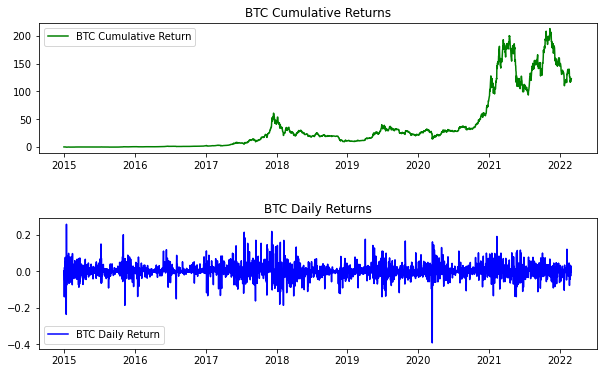

In [8]:
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(btc.ret_c, 'g', label = 'BTC Cumulative Return')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(btc.ret, 'b', label = 'BTC Daily Return')

ax1.set_title('BTC Cumulative Returns')
ax2.set_title('BTC Daily Returns')

ax1.legend()
ax2.legend()

plt.subplots_adjust(wspace=0.5, hspace=0.5);



Let's put together some ideas, write a function, and run a simulation. We'll use something called **geometric brownian motion** (GBM). What is GBM? It is a particular **stochastic differential equation**. But, what's important for us is the idea, which is fairly simple. Here's the formula:

$$
dS = \mu S dt + \sigma S dW_t
$$

This says that the change in the stock price has two components - a **drift**, or average increase over time, and a **shock** that it is random at each point in time. The shock is scaled by the standard deviation of returns that you use. So, larger standard deviation, the bigger the shocks can be. This is basically the simplest way that you can model an asset price.

The shocks are what make the price wiggle around around, or else it would just go up over time, based on the drift value that we use.

And, I'll stress - we aren't predicting here, so to speak. We are trying to capture some basic reality about how an asset moves and then seeing what is possible in the future. We aren't making a statement about whether we think an asset is overvalued or undervalued, will go up or down, etc.

You can solve this equation to get the value of the asset at any point in time t. You just need to know the total of all of the shocks at time t.

$$
S(t) = S(0) \exp \left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W(t)\right)
$$

In [9]:
T = 30 # How long is our simulation? Let's do 31 days (0 to 30 the way Python counts)
N = 30 # number of time points in the prediction time horizon, making this the same as T means that we will simulate daily returns 
S_0 = btc.Value[-1] # initial stock price
N_SIM = 100      # How many simulations to run?
mu = btc.ret.mean()
sigma = btc.ret.std()

This is the basic syntax for writing a function in Python.

In [10]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N):
    dt = T/N # One day
    dW = np.random.normal(scale = np.sqrt(dt), 
        size=(n_sims, N))  # The random part
    W = np.cumsum(dW, axis=1)
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
        + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    return S_t

We can look at each piece of the function code, with some numbers hard-coded, to get a sense of what's going on.

In [11]:
# Creates 100 rows of 30 random numbers from the standard normal distribution.
dW = np.random.normal(scale = np.sqrt(1), 
        size=(100, 30))

# cumulative sum along each row
W = np.cumsum(dW, axis=1) 

# Array with numbers from 1 to 30
time_step = np.linspace(1, 30, 30)

# Expands that to be 100 rows of numbers from 1 to 30. This is going to be the t in the formula above.
time_steps = np.broadcast_to(time_step, (100, 30))

# This is the formula from above to find the value of the asset any any point in time t. np.exp is the natural number e. W is the cumulative sum of all of our random shocks.
S_t = S_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps + sigma * W)

# This inserts the initial price at the start of each row.
S_t = np.insert(S_t, 0, S_0, axis=1)


I do this kind of step-by-step break down **all of the time**. It's the only way I can understand what's going on.

We can then use our function. This returns an `narray`. 

In [12]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

And, we can plot all of the simulations. I'm going to use `pandas` to plot, save to `ax`, and the style the `ax`.

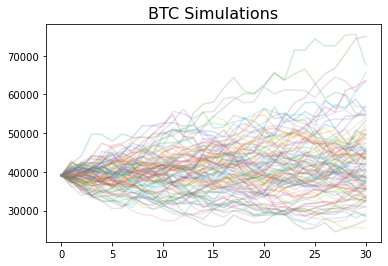

In [13]:
gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)

ax.set_title('BTC Simulations', fontsize=16);
